In [1]:
import numpy as np
from sklearn.datasets import make_classification
from mapie.calibration import MapieCalibrator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import assessment


In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

random_state = 42

X, y = make_classification(
    n_samples=100000,
    n_classes=9,
    n_informative=8,
    random_state=random_state
)

y += 1


X_train, X_, y_train, y_ = train_test_split(
    X, y, test_size=0.33, random_state=random_state)


X_calib, X_test, y_calib, y_test = train_test_split(
    X_, y_, test_size=0.33, random_state=random_state)

reg_ = LogisticRegression(multi_class="multinomial")
reg_.fit(X_train, y_train)

preds_calib = reg_.predict_proba(X_calib)
preds_test = reg_.predict_proba(X_test)

arg_max_preds_test = np.argmax(preds_test, axis=1)


y_pred = reg_.predict(X_test)
accuracy_score(y_test, y_pred)


0.4308539944903581

In [3]:
mapie_cal = MapieCalibrator(
    estimator=LogisticRegression(multi_class="multinomial"),
    calibration_method="sigmoid"
)
mapie_cal.fit(X=X_train, y=y_train, X_calib=X_calib, y_calib=y_calib)
y_pred_test_calibr = mapie_cal.predict_proba(X_test)
y_pred_test_uncalibr = mapie_cal.uncalib_pred

y_pred_test_calibr_max = np.max(y_pred_test_calibr ,axis=1)
y_pred_test_uncalibr_max = np.max(y_pred_test_uncalibr ,axis=1)

argmax_ = np.argmax(y_pred_test_uncalibr, axis=1)+1
print("Checking that the score is the same: ", np.round(accuracy_score(y_test, argmax_), 4))

Checking that the score is the same:  0.4309


In [4]:
from utils_other import ece
from mapie.metrics import expected_calibration_error


their_ece = ece(np.random.random(51), np.random.random(51))
our_ece = expected_calibration_error(np.random.random(51), np.random.random(51))

print(their_ece)
print(our_ece)

Using 15 adaptive bins for ECE estimation.
0.2253237496958149
0.30294405622932763


In [5]:
from utils_other import toplabel_ece

uncalib_ece = toplabel_ece(y_test, y_pred_test_uncalibr_max, pred_class=argmax_)
calib_ece = toplabel_ece(y_test, y_pred_test_calibr_max, pred_class=argmax_)

print("UNcalib: ", uncalib_ece, " and calib: ", calib_ece)
print(np.round(uncalib_ece-calib_ece, 5))

0.01676


In [10]:
from mapie.metrics import top_label_ece

split_strategy = "uniform"
num_bins = 50

uncalib_ece = top_label_ece(
    y_scores=y_pred_test_uncalibr,
    y_true=y_test,
    split_strategy=split_strategy,
    num_bins=num_bins
)

calib_ece = top_label_ece(
    y_scores=y_pred_test_calibr,
    y_true=y_test,
    split_strategy=split_strategy,
    num_bins=num_bins
)

print("UNcalib: ", uncalib_ece, " and calib: ", calib_ece)
print(np.round(uncalib_ece-calib_ece, 5))

uncalib
calib
UNcalib:  0.07908157891736661  and calib:  0.05607810939287662
0.023


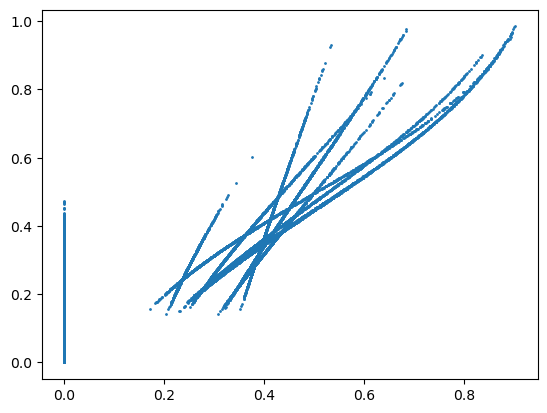

In [11]:
plt.scatter(y_pred_test_calibr, y_pred_test_uncalibr, s=1)

AssertionError: Check dimensions of input matrices

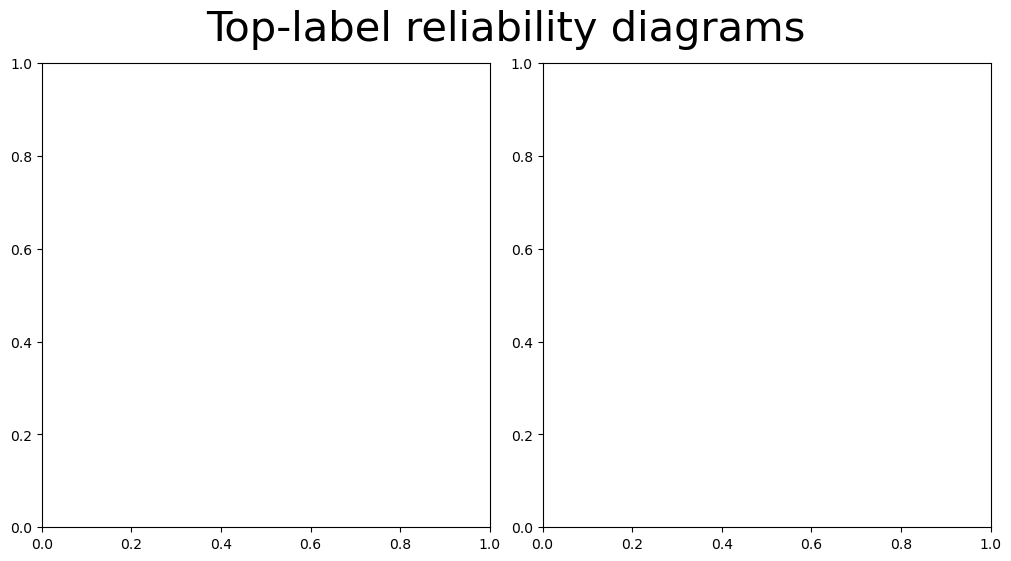

In [9]:
# make some plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5.5), constrained_layout=True)
fig.suptitle('Top-label reliability diagrams', fontsize=30)

assessment.toplabel_reliability_diagram(y_test, y_pred_test_uncalibr, argmax_, ax=ax[0], color='g')
ax[0].set_title("UNCALIB\n (Top-label-ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, y_pred_test_uncalibr, argmax_)));


assessment.toplabel_reliability_diagram(y_test, y_pred_test_calibr, argmax_, ax=ax[1], color='g')
ax[1].set_title("CALIB\n (Top-label-ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, y_pred_test_calibr, argmax_)));

In [ ]:
mapie_cal.estimator